In [1]:
from fastbook import *
from fastai.vision.all import *
from torchvision.utils import save_image

In [2]:
cloud_path = URLs.path('clouds')

In [3]:
cloud_path.ls()

(#6) [Path('/storage/archive/clouds/sample_submission.csv'),Path('/storage/archive/clouds/test_images'),Path('/storage/archive/clouds/codes.txt'),Path('/storage/archive/clouds/train_images'),Path('/storage/archive/clouds/train_images_labels'),Path('/storage/archive/clouds/train.csv')]

In [4]:
train_images_path = cloud_path/'train_images'
label_images_path = cloud_path/'train_images_labels'
codes = list(pd.read_csv(cloud_path/'codes.txt', header=None)[0])

In [5]:
train_image_paths = get_image_files(train_images_path)
train_label_paths = get_image_files(label_images_path)

In [6]:
len(train_image_paths), len(train_label_paths)

(4948, 4948)

## from files to dataloaders

In [7]:
def get_label_img_path(train_img_path):
    train_image_fn = Path(train_img_path.name)
    label_img_fn = train_image_fn.with_suffix('.png')
    return label_images_path/label_img_fn

In [8]:
class MaskedClouds(fastuple):
    def show(self, ctx=None, **kwargs):
        img, mask = self
        if not isinstance(img, Tensor):
            img, mask = tensor(img), tensor(mask)
        img = img.permute(2, 0, 1)
        mask = 255 * torch.stack([mask, mask, mask])
        line = img.new_zeros(img.shape[0], img.shape[1], 10)
        line[0, :, :] = 255
        return show_image(torch.cat([img, line, mask], dim=2), ctx=ctx)

In [9]:
class CloudsTransform(Transform):
    def __init__(self, code):
        self.code = code
    
    def encodes(self, train_img_path):
        train_img_tensor = tensor(PILImage.create(train_img_path))
        mask_path = get_label_img_path(train_img_path)
        stacked_masks = tensor(PILImage.create(mask_path))
        return MaskedClouds(train_img_tensor, stacked_masks[:, :, codes.index(self.code)])

In [10]:
tfm = CloudsTransform('Fish')

In [11]:
x, y = tfm(train_image_paths[2])

In [12]:
x.shape, y.shape

(torch.Size([1400, 2100, 3]), torch.Size([1400, 2100]))

<AxesSubplot:>

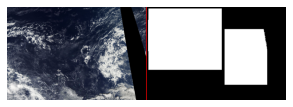

In [13]:
tfm(train_image_paths[170]).show()

In [14]:
splits = RandomSplitter()(train_image_paths)
tls = TfmdLists(train_image_paths, tfm, splits=splits)

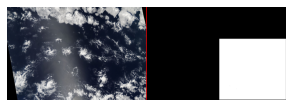

In [15]:
show_at(tls.train, 5);

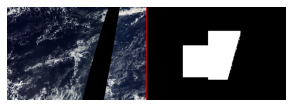

In [16]:
show_at(tls.valid, 5);

In [17]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [19]:
%debug
dls.show_batch(nrows=3, ncols=1)

> /opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/data/core.py(14)show_batch()
     12 def show_batch(x, y, samples, ctxs=None, max_n=9, **kwargs):
     13     if ctxs is None: ctxs = Inf.nones
---> 14     if hasattr(samples[0], 'show'):
     15         ctxs = [s.show(ctx=c, **kwargs) for s,c,_ in zip(samples,ctxs,range(max_n))]
     16     else:

ipdb> x.shape
*** AttributeError: 'MaskedClouds' object has no attribute 'shape'
ipdb> y.shape
*** AttributeError: 'NoneType' object has no attribute 'shape'
ipdb> type(samples)
<class 'NoneType'>
ipdb> max_n
9
ipdb> type(ctxs)
<class 'itertools.cycle'>
ipdb> 
<class 'itertools.cycle'>
ipdb> 
<class 'itertools.cycle'>
ipdb> 
<class 'itertools.cycle'>
ipdb> exit


TypeError: 'NoneType' object is not subscriptable

#### https://docs.fast.ai/tutorial.siamese.html <- answer how to make show_batch work is probably here